# Business Problem

Chicago needs to face an epidemic of violence within the city. One way to face the problem is to use machine learning to determine how many victims of violent crime to expect on a given day. Using data from the city of Chicago, I will train regression models to predict upcoming crimes.

The underlying principal of this project is fairly intuitive: violent acts will lead to more violent acts. However, this project will examine the victims of violent crime in Chicago and see if differing victims (different ages, sexes, races, etc) effect predictions for future violent crime.

The model itself be created for the Chicago government to help predict the amount of first responders needed on a given day. For example, if a spike in crime occurs on a given day, the Chicago PD can proactively schedule more police officers and 911 operators.

In [1]:
# Importing and settings
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate
from statsmodels.formula.api import ols
from sklearn.pipeline import Pipeline
import statsmodels.api as sm
import pickle
pd.set_option('display.max_colwidth',1000)
pd.set_option('display.max_columns', None)

## Loading Data and Cleaning

First the data needs to be loaded in and checked to make sure that there is no missing data. I will also ensure there are no odd values.

In [2]:
df = pd.read_csv('violent_crime.csv')

# Standardize column headers
df.columns = df.columns.str.lower()
df.columns = df.columns.str.replace(' ','_')

In [3]:
df.head(3)

,case_number,date,block,primary_type,unique_id,zip_code,ward,community_area,street_outreach_organization,area,district,beat,age,sex,race,fbi_cd,fbi_descr,iucr_cd,iucr_secondary,month,day_of_week,hour,latitude,longitude,location
0,HZ100096,01/01/2016 02:04:00 AM,4600 S ST LAWRENCE,FATAL SHOOTING,HOM-HZ100096-1,60653,4,GRAND BOULEVARD,None,1,2,221,20 - 29,M,BLK,01A,HOMICIDE - 1ST OR 2ND DEGREE (INDEX),0110,FIRST DEGREE MURDER,1,6,2,41.810127,-87.611604,POINT (-87.611604058699 41.810126904142)
1,HZ100342,01/01/2016 06:39:00 AM,1900 W GARFIELD BLVD,FATAL SHOOTING,HOM-HZ100342-1,60609,16,NEW CITY,PBMR New City,1,9,932,30 - 39,M,BLK,01A,HOMICIDE - 1ST OR 2ND DEGREE (INDEX),0110,FIRST DEGREE MURDER,1,6,6,41.794218,-87.673175,POINT (-87.67317465388 41.794218345858)
2,HZ101042,01/01/2016 10:06:00 PM,6100 S SANGAMON ST,FATAL SHOOTING,HOM-HZ101042-1,60621,16,ENGLEWOOD,TADC Englewood | READI 60621,1,7,712,30 - 39,M,BLK,01A,HOMICIDE - 1ST OR 2ND DEGREE (INDEX),0110,FIRST DEGREE MURDER,1,6,22,41.782338,-87.647905,POINT (-87.64790465388 41.782338345858)


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20036 entries, 0 to 20035
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   case_number                   20036 non-null  object 
 1   date                          20036 non-null  object 
 2   block                         20036 non-null  object 
 3   primary_type                  20036 non-null  object 
 4   unique_id                     20036 non-null  object 
 5   zip_code                      20036 non-null  int64  
 6   ward                          20036 non-null  int64  
 7   community_area                20036 non-null  object 
 8   street_outreach_organization  20036 non-null  object 
 9   area                          20036 non-null  int64  
 10  district                      20036 non-null  int64  
 11  beat                          20036 non-null  int64  
 12  age                           19801 non-null  object 
 13  s

In [5]:
# Info shows that there are missing values in age, race, and sex. 
# Will fill in with corresponding unknown values their columns.

df['age'].fillna('UNKNOWN', inplace=True)
df['sex'].fillna('UNKNOWN', inplace=True)
df['race'].fillna('(NOT PROVIDED)', inplace=True)

In [6]:
# Sex has a few ambiguous values, so going to put them under one banner
df['sex'].replace(['UNKNOWN','X', '(NOT PROVIDED)'], 'SEX_UNKNOWN', inplace=True)
df['sex'].unique()

array(['M', 'F', 'SEX_UNKNOWN'], dtype=object)

In [7]:
df['street_outreach_organization'].value_counts()

None                                                       5100
READI 60644 | INVC Austin                                  1132
UCAN North Lawndale | READI 60623                           875
TADC Englewood | READI 60621                                864
ALSO Humboldt Park                                          825
                                                           ... 
TADC Englewood | READI 60621 | Acclivus Washington Park       1
SWOP Gage Park | READI 60631                                  1
TADC West Englewood                                           1
READI 60623 | New Life Centers Brighton Park                  1
New Life Centers South Lawndale                               1
Name: street_outreach_organization, Length: 78, dtype: int64

There is a feature in the data about community outreach available near where the crime happened. There are many different organizations, some with value counts of 1, so I am going make it a more binary predictor of whether or not street outreache was available.

In [8]:
def help_available(string):
    if string == 'None':
        return 'no'
    else:
        return 'yes'

In [9]:
df['so_yes_no'] = df['street_outreach_organization'].map(help_available)

## Early Data Analysis

Now that I'm satisfied with the data, it is important to look at the data and see if there are any trends that may effect the model, or if there are any opportunities for feature engineering. 

In [10]:
df['so_yes_no'].value_counts(normalize=True)

yes    0.745458
no     0.254542
Name: so_yes_no, dtype: float64

In [11]:
df['sex'].value_counts(normalize=True)

M              0.861499
F              0.126273
SEX_UNKNOWN    0.012228
Name: sex, dtype: float64

In [12]:
df['race'].value_counts(normalize=True)

BLK               0.784688
WWH               0.157317
WHI               0.025504
(NOT PROVIDED)    0.020663
WBH               0.006488
API               0.003843
U                 0.001298
I                 0.000200
Name: race, dtype: float64

In [13]:
df['age'].value_counts(normalize=True)

20 - 29    0.446896
30 - 39    0.216261
0 - 19     0.200040
40 - 49    0.074466
50 - 59    0.034438
60 - 69    0.012577
UNKNOWN    0.011729
70 - 79    0.002446
80+        0.001148
Name: age, dtype: float64

So far there is nothing too surprsing in the data. I am going to eventually look into applying my model to specific neighborhoods, so I want to see where victims are concentrated.

In [14]:
df_loc = df.groupby('community_area', as_index=False).count()

In [15]:
df_loc = df_loc[['community_area', 'unique_id']]
df_loc

,community_area,unique_id
0,ALBANY PARK,99
1,ARCHER HEIGHTS,40
2,ARMOUR SQUARE,63
3,ASHBURN,122
4,AUBURN GRESHAM,818
...,...,...
72,WEST LAWN,58
73,WEST PULLMAN,514
74,WEST RIDGE,97
75,WEST TOWN,301


In [16]:
chi_nei = gpd.read_file('location_data/CommAreas.shp')

In [17]:
merge_loc = chi_nei.merge(df_loc, left_on='COMMUNITY', right_on='community_area')

In [18]:
merge_loc[merge_loc['unique_id'] > 800][['COMMUNITY', 'unique_id']]

,COMMUNITY,unique_id
23,HUMBOLDT PARK,972
25,AUSTIN,2086
26,WEST GARFIELD PARK,889
29,NORTH LAWNDALE,1227
64,WEST ENGLEWOOD,833
65,ENGLEWOOD,885
69,AUBURN GRESHAM,818


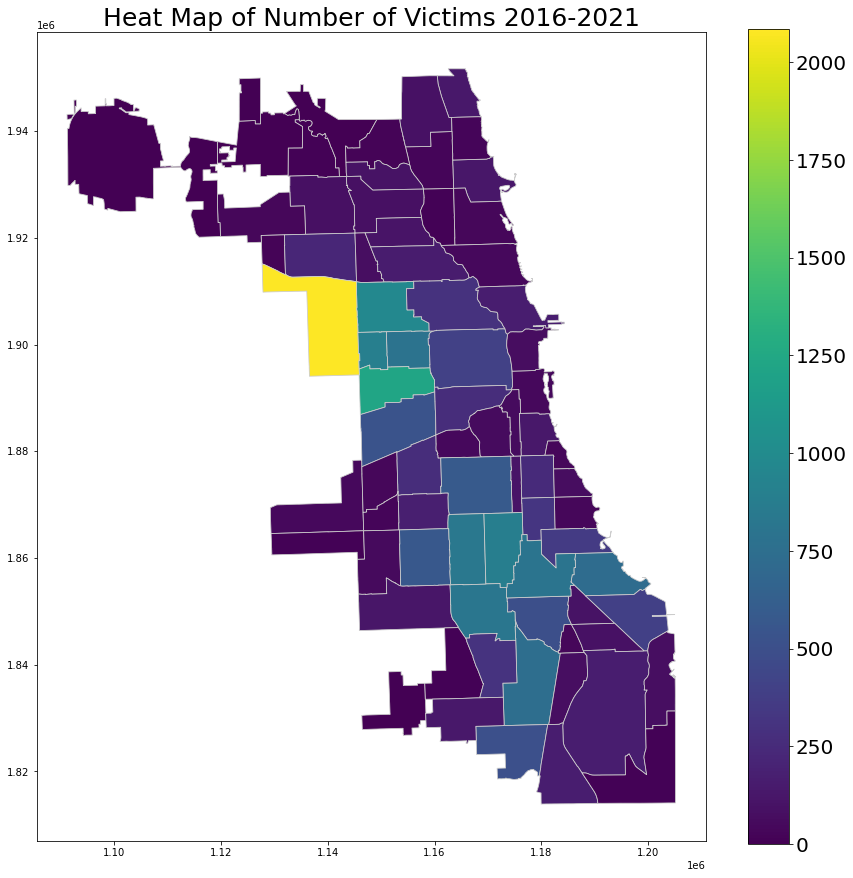

In [19]:
fig, ax = plt.subplots(figsize=(15,15))
ax.set_title('Heat Map of Number of Victims 2016-2021', fontdict={'fontsize': '25', 'fontweight': '1'})
vmin, vmax = 0, 2086
sc_ma = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax))
sc_ma._A = []
cbar = fig.colorbar(sc_ma)
cbar.ax.tick_params(labelsize=20)
merge_loc.plot('unique_id', linewidth=0.8, ax=ax, edgecolor='0.8', figsize=(40,20));

We can see that violent crime appears to be be clustered heavily in west side of the city (mostly Austin), with a smaller cluster in the south side.

Next, I want to format the dates and see if there are any patterns in temporal data (day of week, month and month of the year).

In [20]:
# Formatting date and adding specification of month and year
df['date'] = pd.to_datetime(df['date'])
df['month_year'] = pd.to_datetime(df['date']).dt.to_period('M')
df['date'] = df['date'].dt.to_period('D')

In [21]:
df_dow = df.groupby('day_of_week').count()

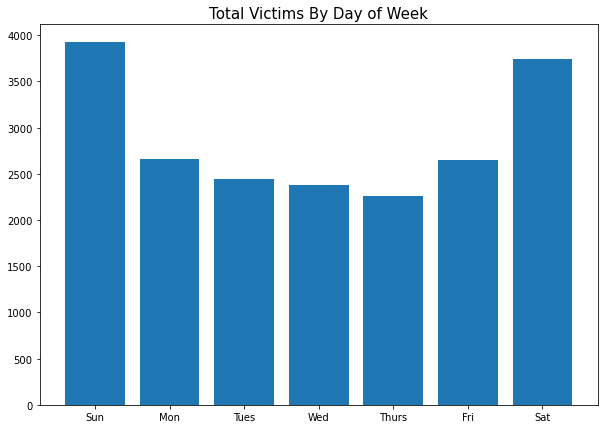

In [22]:
day_list = ['Sun', 'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat']

fig, ax = plt.subplots(figsize=(10,7))
ax.bar(day_list ,df_dow['unique_id'])
ax.set_title('Total Victims By Day of Week', fontdict={'fontsize': '15'});

In [23]:
df_month = df.groupby('month').count()
df_month.reset_index(inplace=True)

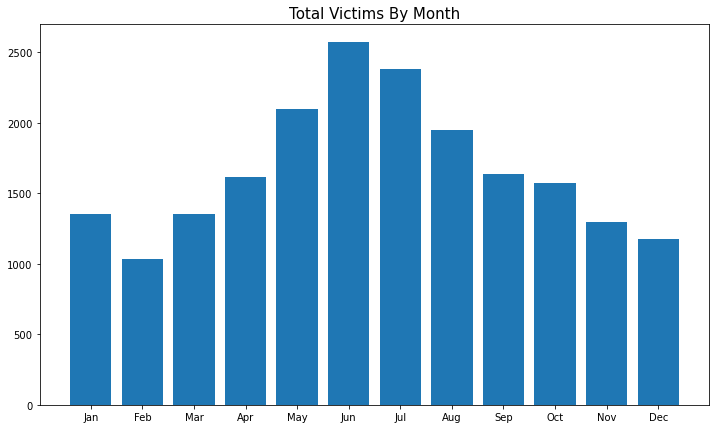

In [24]:
month_list = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

fig, ax = plt.subplots(figsize=(12,7))
ax.bar(month_list ,df_month['unique_id'])
ax.set_title('Total Victims By Month', fontdict={'fontsize': '15'});

In [25]:
# df['month_year'] = pd.to_datetime(df['date']).dt.to_period('M')

In [26]:
df_month_year = df.groupby('month_year').count()
df_month_year.reset_index(inplace=True)

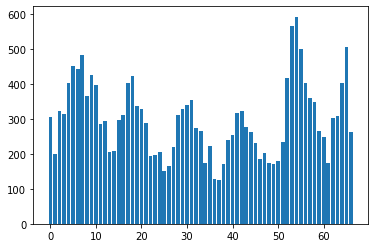

In [27]:
plt.bar(df_month_year.index, df_month_year['unique_id']);

We can see patterns in all of the temporal data:

* There tends to be victims on weekends
* There appears to be more victims in hotter months
* Up until 2020, violent crime was on a downward trend

Based on this, I will expect that day of week, month, and month_year will be good predictors in my model. Let's find out!

## Formatting Data

Right now, each row of data is one victim of a violent crime. However, I want the model to predict the total number of vicitms on a given day. Additionally, a lot of data is numeric when I would like it to be categorical (ie day of week is 1-7 rather than name of the day). Finally, I want to get a count of the different type of victims (victims by age, sex, proximity to street outreach, etc).

In [28]:
# Originally was going to not use 
df = df[df['date'] < '2020-01-01']

df.reset_index(inplace=True)

In [29]:
# Changing types to fatal or non-fatal

df['primary_type'].replace(['NON-SHOOTING HOMICIDE', 'FATAL SHOOTING'], 'fatal', inplace=True)
df['primary_type'].replace(['NON-FATAL SHOOTING'], 'non_fatal', inplace=True)

In [30]:
# Function to one hot encode categorical features

def cat_encoder(category, enc_df):
    ohe = OneHotEncoder(handle_unknown='error', sparse=False)
    
    temp_df = enc_df[[category]]
    ohe.fit(temp_df)

    cat_encoded = pd.DataFrame(ohe.transform(temp_df).astype(int), \
                               columns=(category+'_'+ohe.categories_[0]))
    return cat_encoded

For the first models, I am going to focus on non-spatial data, and essentially throw everything else in and check out what appears to be good indicators for models. From there, I can set up a new dataframe with the best features to see if the models will become more accurate.

In [31]:
model_vars = ['date', 'primary_type', 'day_of_week', 'month', 'month_year', 'so_yes_no', 'beat', 
              'age', 'sex', 'race', 'community_area']
model_df = df[model_vars]
model_df = model_df.astype(str)

In [32]:
model_df.reset_index(inplace=True, drop=True)
model_df

,date,primary_type,day_of_week,month,month_year,so_yes_no,beat,age,sex,race,community_area
0,2016-01-01,fatal,6,1,2016-01,no,221,20 - 29,M,BLK,GRAND BOULEVARD
1,2016-01-01,fatal,6,1,2016-01,yes,932,30 - 39,M,BLK,NEW CITY
2,2016-01-01,fatal,6,1,2016-01,yes,712,30 - 39,M,BLK,ENGLEWOOD
3,2016-01-02,fatal,7,1,2016-01,yes,314,0 - 19,M,BLK,WOODLAWN
4,2016-01-04,fatal,2,1,2016-01,yes,1523,20 - 29,M,BLK,AUSTIN
...,...,...,...,...,...,...,...,...,...,...,...
13613,2018-01-21,non_fatal,1,1,2018-01,no,2011,20 - 29,M,BLK,WEST RIDGE
13614,2017-06-17,fatal,7,6,2017-06,yes,711,0 - 19,M,BLK,ENGLEWOOD
13615,2016-09-15,non_fatal,5,9,2016-09,no,1624,0 - 19,M,WWH,PORTAGE PARK
13616,2017-07-07,non_fatal,6,7,2017-07,yes,1522,30 - 39,M,WWH,AUSTIN


In [33]:
# Everything but date needs to be encoded

need_enc = list(model_df.columns[1:])

for col in need_enc:
    loop_df = cat_encoder(str(col), model_df)
    model_df = pd.concat([model_df, loop_df], axis=1)

In [34]:
model_df = model_df.groupby('date').sum()

In [35]:
model_df = model_df[model_df['primary_type_non_fatal']<40]

The target of the model is total victims on a given day. As such, I can add all victims of fatal and non-fatal incidents to get the total victims.

In [36]:
target = model_df['primary_type_fatal'] + model_df['primary_type_non_fatal']
target

date
2016-01-01    18
2016-01-02     9
2016-01-03    12
2016-01-04     6
2016-01-05    13
              ..
2019-12-27    11
2019-12-28    10
2019-12-29     8
2019-12-30     5
2019-12-31     8
Length: 1458, dtype: int64

Now the data is arranged by date, and I have a count of victims by different categories on each day. However, in some cases I want the data to be binary, like day of week, month, and month_year.

In [37]:
# Function to change sum to binary

def binary_maker(num):
    if num > 0:
        return 1
    else:
        return 0

In [38]:
# Separating sum and binary data

time_list = []
count_list = []

for col in model_df.columns:
    if 'day' in col or 'month' in col:
        time_list.append(col)
    else:
        count_list.append(col)
        
time_df = model_df[time_list]

In [39]:
# Using function on day and month features

for col in time_df:
    time_df[col] = time_df[col].map(binary_maker)

# Will use rolling function for past two days for sum data, so need to drop the first two rows for binary data 
time_df = time_df[7:]

<ipython-input-39-bbb0e27f21d5>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_df[col] = time_df[col].map(binary_maker)


In [40]:
# model_df.set_index('date', inplace=True)

# Get rolling sum of victims from last two days
model_df = model_df[count_list]
model_df = model_df.rolling(window=7).sum().shift()

# Remove first two rows
model_df = model_df[7:]

# Concat the rolling and binary data
model_df = pd.concat([model_df, time_df], axis=1)

In [41]:
# For binary data, dropping first

model_df.drop('month_1', axis=1, inplace=True)
model_df.drop('month_year_2016-01', axis=1, inplace=True)
model_df.drop('day_of_week_7', axis=1, inplace=True)

## Building the Model

The first thing to do is build models with everything added and trying to determine if there is too much noise in the data. From there, I can test the models after stripping out some features, choose high performing models and try to further optimize those models.

In [42]:
X = model_df
y = target[7:]

In [43]:
y[y>70]

Series([], dtype: int64)

In [44]:
X.isna().sum()

primary_type_fatal        0
primary_type_non_fatal    0
so_yes_no_no              0
so_yes_no_yes             0
beat_1011                 0
                         ..
month_year_2019-08        0
month_year_2019-09        0
month_year_2019-10        0
month_year_2019-11        0
month_year_2019-12        0
Length: 429, dtype: int64

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

ss = StandardScaler()
Xtr_scaled = pd.DataFrame(ss.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
Xte_scaled = pd.DataFrame(ss.fit_transform(X_test), columns=X_test.columns, index=X_test.index)

### Linear Regression

In [46]:
lin_model = LinearRegression()

lin_model.fit(Xtr_scaled, y_train)
print('Train Score: ' , lin_model.score(Xtr_scaled, y_train))
print('Test Score:  ' , lin_model.score(Xte_scaled, y_test))

Train Score:  0.6405731052236243
Test Score:   -1.7875794040809322e+22


In [47]:
sm.OLS(y_train, sm.add_constant(Xtr_scaled)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.641
Model:                            OLS   Adj. R-squared:                  0.448
Method:                 Least Squares   F-statistic:                     3.318
Date:                Thu, 19 Aug 2021   Prob (F-statistic):           3.82e-46
Time:                        16:30:10   Log-Likelihood:                -3033.1
No. Observations:                1160   AIC:                             6878.
Df Residuals:                     754   BIC:                             8931.
Df Model:                         405                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                     9.2483      0.120     76.808      0.000       9.012       9.485
primary_type_fatal                       -0.1295      0.444     -0.292      0.771      -1.001       0.742
primary_type_non_fatal                   -0.3884      0.318     -1.221      0.222      -1.013       0.236
so_yes_no_no                              0.0618      1.178      0.052      0.958      -2.251       2.374
so_yes_no_yes                            -0.4788      0.581     -0.824      0.410      -1.620       0.662
beat_1011                                 2.2558      2.921      0.772      0.440      -3.479       7.991
beat_1012                                 1.7142      2.176      0.788      0.431      -2.559       5.987
beat_1013                                 0.6426      1.643      0.391      0.696      -2.584       3.869
beat_1014                                 1.1137      1.554      0.717      0.474      -1.937       4.164
beat_1021                                 1.8647      2.719      0.686      0.493      -3.473       7.202
beat_1022                                 1.2088      2.529      0.478      0.633      -3.755       6.173
beat_1023                                 0.7244      1.204      0.602      0.548      -1.640       3.088
beat_1024                                 0.7735      1.964      0.394      0.694      -3.082       4.629
beat_1031                                 0.5409      1.535      0.352      0.725      -2.473       3.554
beat_1032                                -0.2016      1.181     -0.171      0.864      -2.520       2.117
beat_1033                                 0.0078      1.732      0.005      0.996      -3.391       3.407
beat_1034                                 0.5208      1.463      0.356      0.722      -2.351       3.392
beat_111                                  0.4283      0.348      1.230      0.219      -0.255       1.112
beat_1111                                 0.7855      1.916      0.410      0.682      -2.976       4.547
beat_1112                                 1.2576      2.876      0.437      0.662      -4.388       6.903
beat_1113                                 2.3719      2.671      0.888      0.375      -2.872       7.615
beat_1114                                 0.4340      1.329      0.326      0.744      -2.175       3.043
beat_1115                                 1.9671      2.054      0.958      0.339      -2.065       5.999
beat_112                                  0.1299      0.295      0.440      0.660      -0.449       0.709
beat_1121                                 0.9536      2.468      0.386      0.699      -3.891       5.798
beat_1122                                 2.0947      2.141      0.978      0.328      -2.108       6.298
beat_1123

Looking at variables, the only variables with a p-value less than .05 are temporal variables (day of week, month). The original theory for this project was that the amount of recent violence on a given day could be predicted based on the amount of recent victims. So far, it seems like that theory may not hold up. 

However, we can investigate more models to see if this holds up.

### Decision Tree

In [48]:
tree_model = DecisionTreeRegressor()

tree_model.fit(Xtr_scaled, y_train)
tree_model.score(Xtr_scaled, y_train)

1.0

In [49]:
tree_model.score(Xte_scaled, y_test)

-0.3030084172072367

In [50]:
tree_fi = list(zip(tree_model.feature_importances_, Xtr_scaled.columns))
sorted(tree_fi, reverse=True)[:15]

[(0.20859242901049158, 'race_BLK'),
 (0.04982718175986102, 'day_of_week_1'),
 (0.04383890357561645, 'sex_M'),
 (0.025903903726320173, 'beat_1131'),
 (0.024131312699361376, 'so_yes_no_no'),
 (0.020777437352420096, 'so_yes_no_yes'),
 (0.019493963336583518, 'age_30 - 39'),
 (0.016984008236770456, 'month_8'),
 (0.015854923121139827, 'age_0 - 19'),
 (0.01574979755213061, 'community_area_LAKE VIEW'),
 (0.015456426306710944, 'race_WHI'),
 (0.015231997670714315, 'beat_313'),
 (0.01365162849048742, 'beat_1821'),
 (0.013614624953237953, 'community_area_AUSTIN'),
 (0.013286205474595627, 'primary_type_non_fatal')]

### Stochastic Gradient Descent

In [51]:
sgd_model = SGDRegressor()

sgd_model.fit(Xtr_scaled, y_train)
sgd_model.score(Xtr_scaled, y_train)

0.5966177079346984

In [52]:
sgd_model.score(Xte_scaled, y_test)

0.049041234579062065

In [53]:
sgd_fi = list(zip(abs(sgd_model.coef_), Xtr_scaled.columns))
sorted(sgd_fi, reverse=True)[:15]

[(1.9942054853509932, 'month_year_2016-08'),
 (1.8637008714645058, 'day_of_week_4'),
 (1.8049956426205442, 'day_of_week_5'),
 (1.6721832331294246, 'day_of_week_3'),
 (1.4698996858975149, 'day_of_week_2'),
 (1.451578577667341, 'day_of_week_6'),
 (1.3987862131667566, 'month_year_2019-01'),
 (1.0687621294631007, 'community_area_BELMONT CRAGIN'),
 (1.0392607749154765, 'month_year_2016-07'),
 (0.9677995289366312, 'month_year_2016-10'),
 (0.9644986082573709, 'month_year_2016-06'),
 (0.9623726719674842, 'month_year_2019-10'),
 (0.8873521988548052, 'month_year_2019-08'),
 (0.8486537698881532, 'month_year_2017-07'),
 (0.8375878519877454, 'community_area_WEST GARFIELD PARK')]

### Support Vector Regression

In [54]:
svr_model = SVR(kernel='linear')

svr_model.fit(Xtr_scaled, y_train)
svr_model.score(Xtr_scaled, y_train)

0.5213286644283521

In [55]:
svr_model.score(Xte_scaled, y_test)

-0.03762057917681583

In [56]:
svr_fi = list(zip(abs(svr_model.coef_[0]), Xtr_scaled.columns))
sorted(svr_fi, reverse=True)[:15]

[(1.7855518309680074, 'month_year_2019-01'),
 (1.666043926945169, 'month_year_2016-08'),
 (1.5598400850499754, 'community_area_ENGLEWOOD'),
 (1.5253522837255036, 'month_year_2019-07'),
 (1.5055670977672568, 'community_area_EDGEWATER'),
 (1.4768012656858815, 'day_of_week_5'),
 (1.4736277744016992, 'beat_431'),
 (1.4539865955132711, 'day_of_week_4'),
 (1.3961140266060874, 'community_area_WEST ENGLEWOOD'),
 (1.3939333727885317, 'community_area_BELMONT CRAGIN'),
 (1.3178118695024785, 'beat_2433'),
 (1.310001195783595, 'beat_713'),
 (1.2858256796267251, 'day_of_week_3'),
 (1.2596226785974225, 'month_year_2019-08'),
 (1.2583163729819529, 'day_of_week_2')]

## Refining the Models

The rest of the models appear to more or less show the same thing. Temporal data is important, while the rest does not appear to be impactful. It does appear that the decision tree model took advantage of features where the majority class count was selected (race_black, sex_male, etc), indicating that the overall count seems to have some impact.

It looks like community area is important in a lot of models, so I will try models both with or without community area. Street Outreach and Day of Week since count of victims and day of week seems to consistently be important.

### With Community Area

In [57]:
top_list = []

for col in X.columns:
    if 'day_of_week' in col or 'month' in col or 'so_yes_no' in col or 'community_area' and 'year' not in col:
        top_list.append(col)

In [58]:
X_top = X[top_list]

Xtr_top, Xte_top, ytr_top, yte_top = train_test_split(X_top, y)

Xtr_top_scaled = pd.DataFrame(ss.fit_transform(Xtr_top), columns=Xtr_top.columns, index=Xtr_top.index)
Xte_top_scaled = pd.DataFrame(ss.fit_transform(Xte_top), columns=Xte_top.columns, index=Xte_top.index)

In [59]:
lin_top_model = LinearRegression()

lin_top_model.fit(Xtr_top_scaled, ytr_top)

lr_cv = cross_val_score(lin_top_model,
                    Xtr_top_scaled, ytr_top,
                    cv=5)

lr_cv.mean()

-0.40072398008605886

In [60]:
dt_top_model = DecisionTreeRegressor()

dt_top_model.fit(Xtr_top_scaled, ytr_top)

dt_cv = cross_val_score(dt_top_model,
                       Xtr_top_scaled, ytr_top,
                       cv=5)

dt_cv.mean()

-0.38126610290311214

In [61]:
sgd_top_model = SGDRegressor()

sgd_top_model.fit(Xtr_top_scaled, ytr_top)

sgd_cv = cross_val_score(sgd_top_model,
                        Xtr_top_scaled, ytr_top,
                        cv=5)

sgd_cv.mean()

-0.17632021190273187

In [62]:
svr_top_model = SVR(kernel='linear')

svr_top_model.fit(Xtr_top_scaled, ytr_top)

svr_cv = cross_val_score(svr_top_model,
                       Xtr_top_scaled, ytr_top,
                       cv=5)

svr_cv.mean()

-0.25708000665317227

### Without Community Area

In [63]:
top_list = []

for col in X.columns:
    if 'day_of_week' in col or 'so_yes_no' in col or 'month' in col and 'year' not in col:
        top_list.append(col)

In [64]:
X_top = X[top_list]

Xtr_top, Xte_top, ytr_top, yte_top = train_test_split(X_top, y)

Xtr_top_scaled = pd.DataFrame(ss.fit_transform(Xtr_top), columns=Xtr_top.columns, index=Xtr_top.index)
Xte_top_scaled = pd.DataFrame(ss.fit_transform(Xte_top), columns=Xte_top.columns, index=Xte_top.index)

In [65]:
lin_top_model = LinearRegression()

lin_top_model.fit(Xtr_top_scaled, ytr_top)

lr_cv = cross_val_score(lin_top_model,
                    Xtr_top_scaled, ytr_top,
                    cv=5)

lr_cv.mean()

0.3406891986842413

In [66]:
dt_top_model = DecisionTreeRegressor()

dt_top_model.fit(Xtr_top_scaled, ytr_top)

dt_cv = cross_val_score(dt_top_model,
                       Xtr_top_scaled, ytr_top,
                       cv=5)

dt_cv.mean()

-0.3903389881307334

In [67]:
sgd_top_model = SGDRegressor()

sgd_top_model.fit(Xtr_top_scaled, ytr_top)

sgd_cv = cross_val_score(sgd_top_model,
                        Xtr_top_scaled, ytr_top,
                        cv=5)

sgd_cv.mean()

0.3400882446591531

In [68]:
svr_top_model = SVR(kernel='linear')

svr_top_model.fit(Xtr_top_scaled, ytr_top)

svr_cv = cross_val_score(svr_top_model,
                       Xtr_top_scaled, ytr_top,
                       cv=5)

svr_cv.mean()

0.3260076876853219

Community area appears to be set the model back a bit, so we will move forward with only day of week and street outreach.

SGD and SVR seemed to have the best results in cross validation, so I will create param grids foro both of these to do a grid search and see if they can be fine tuned a bit more. Additionally, I want to look at Mean Squared Error here, to get more of a sense of how well my model's predictions will compare to test data.

In [69]:
sgd_param_grid = {'penalty': ['l1', 'l2'],
                 'tol': [.01, .001, .0001],
                 'epsilon': [.1, .01, .001]}

In [70]:
sgd_gs = GridSearchCV(estimator=sgd_top_model,
                      param_grid=sgd_param_grid,
                      scoring='neg_mean_squared_error',
                      cv=10)

In [71]:
sgd_gs.fit(Xtr_top_scaled, ytr_top)

sgd_gs.score(Xte_top_scaled, yte_top)

-20.98542739338889

In [72]:
sgd_gs.best_params_

{'epsilon': 0.1, 'penalty': 'l1', 'tol': 0.01}

In [73]:
svr_param_grid = {'degree': [3,4,5],
              'epsilon': [.1, .01, .001],
              'tol': [.01, .001, .0001]}

In [74]:
svr_gs = GridSearchCV(estimator=svr_top_model,
                         param_grid=svr_param_grid,
                         scoring='neg_mean_squared_error',
                         cv=10)

In [75]:
svr_gs.fit(Xtr_top_scaled, ytr_top)

svr_gs.score(Xte_top_scaled, yte_top)

-21.743056898714805

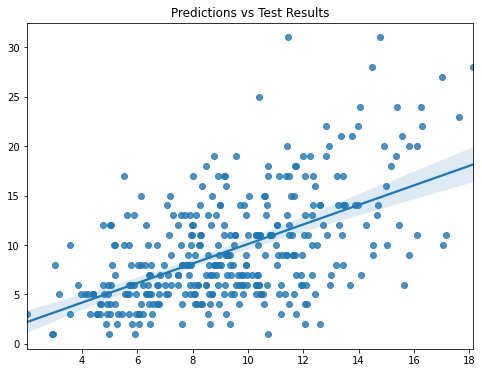

In [76]:
preds = sgd_gs.predict(Xte_top_scaled)

fig, ax = plt.subplots(figsize=(8,6))
sns.regplot(x=preds, y=yte_top).set_title('Predictions vs Test Results');

In [77]:
# Compare to only time data

temporal_list = []

for col in X.columns:
    if 'day_of_week' in col or 'month' in col and 'year' not in col:
        temporal_list.append(col)
        
X_time = X[temporal_list]

Xtr_time, Xte_time, ytr_time, yte_time = train_test_split(X_time, y)

Xtr_time_scaled = pd.DataFrame(ss.fit_transform(Xtr_time), columns=Xtr_time.columns, index=Xtr_time.index)
Xte_time_scaled = pd.DataFrame(ss.fit_transform(Xte_time), columns=Xte_time.columns, index=Xte_time.index)

svr_gs.fit(Xtr_time_scaled, ytr_time)

svr_gs.score(Xte_time_scaled, yte_time)

-22.673582459414078

# Conclusion

Unfortunately, it appears that our model is not currently successful at predicting the amount of victims to be expected on a given day in Chicago. We have a MSE of 19 for both SGD and SVR models, and most data points are below 25 victims.

It appears based on our analysis that the only solid predictors we have are day of week and month. While there does appear to be some truth that recent violence will lead to more acts of violence (adding in that data proved to make the model more reliable), it is not enough to make good predictions for our purposes.

## Pickling a Model for Dashboard

I am still learning Flask, so for right now I am going to have a simplified version of the model for my dashboard. I will continue working on my dashboard to have the full model available!

In [78]:
def weekend(n):
    if n==1 or n==7:
        return 1
    else:
        return 0

In [79]:
df['is_weekend'] = df['day_of_week'].map(weekend)

In [80]:
pickle_df = df.groupby(['date', 'is_weekend'], as_index=False).count()

In [81]:
pickle_df = pickle_df[['date', 'is_weekend', 'unique_id']]
pickle_df.set_index('date', inplace=True)

In [82]:
pickle_target = pickle_df['unique_id']

In [83]:
pickle_df['unique_id'] = pickle_df['unique_id'].rolling(7).sum().shift()

In [84]:
pickle_df = pickle_df[7:]

In [85]:
pickle_target = pickle_target[7:]

In [86]:
Xp_train, Xp_test, yp_train, yp_test = train_test_split(pickle_df, pickle_target)

In [87]:
model_pipeline = Pipeline([('scaler', StandardScaler()),
                          ('sgd', SGDRegressor(epsilon=0.01,  penalty='l2', tol=0.001))])

In [88]:
model_pipeline.fit(Xp_train, yp_train)

model_pipeline.score(Xp_test, yp_test)

0.3640137928264391

In [89]:
with open("chicago_model.pkl", 'wb') as f:
    pickle.dump(model_pipeline, f)